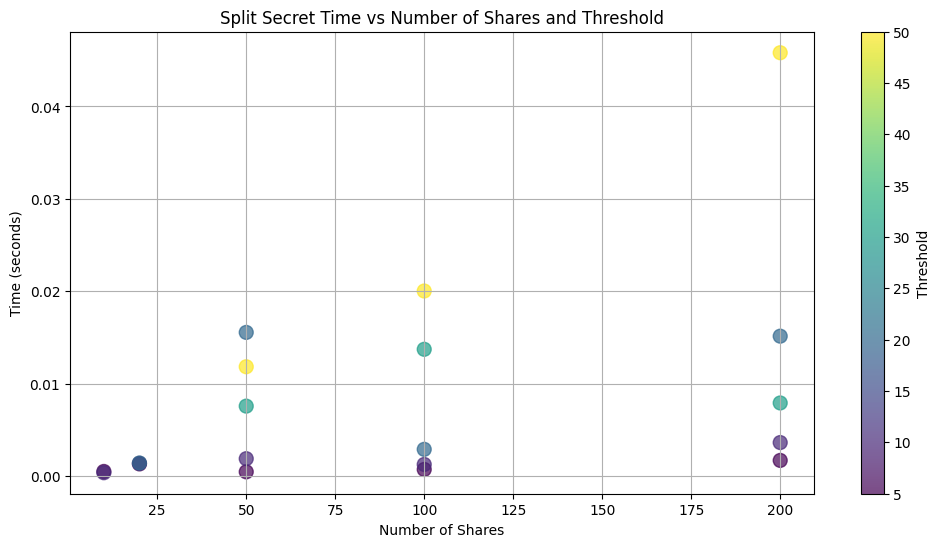

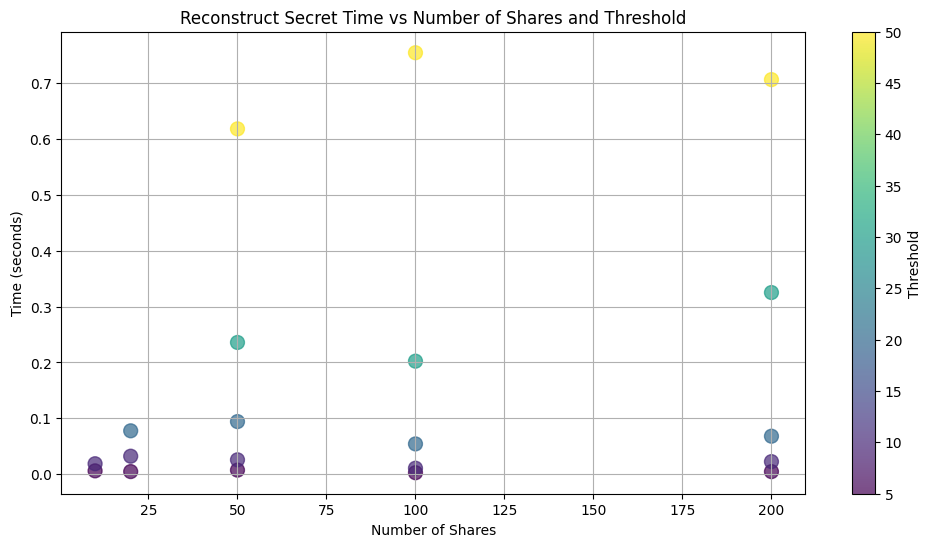

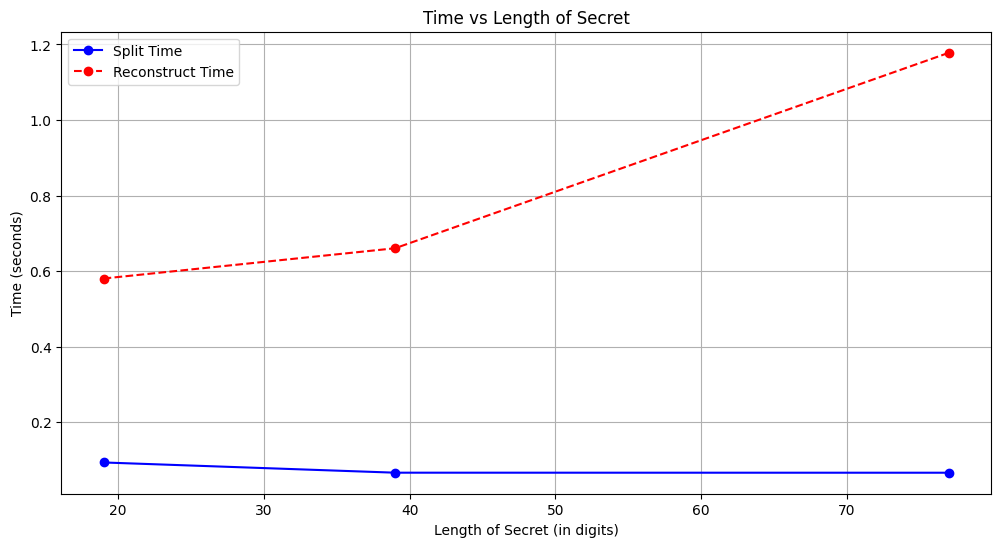

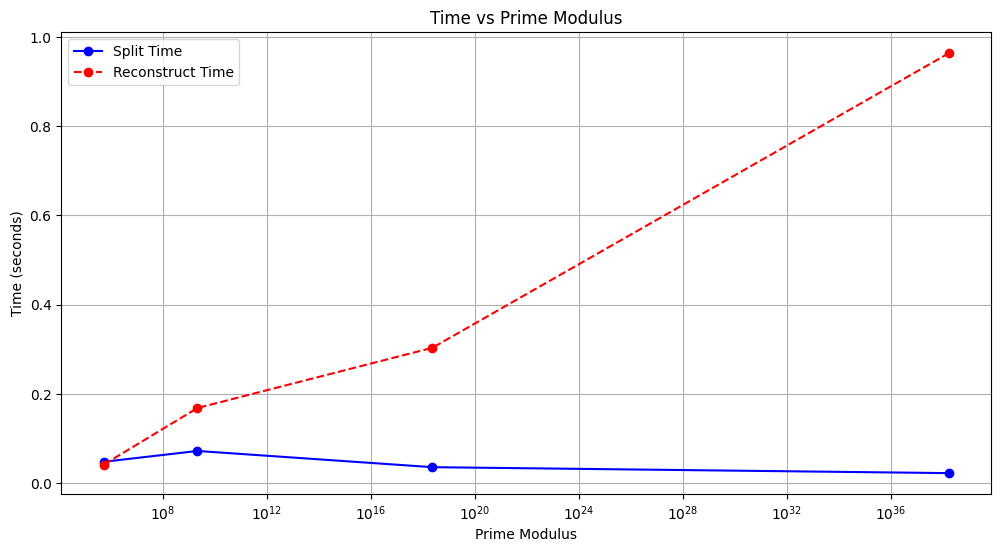

In [1]:
# Ensure necessary libraries are installed
!pip install matplotlib numpy

import random
import numpy as np
import matplotlib.pyplot as plt
from random import SystemRandom
from functools import reduce
from operator import mul
import time

# Function to perform modular inverse
def mod_inverse(a, p):
    return pow(a, p - 2, p)

# Function to perform Lagrange interpolation at x=0 to reconstruct the secret
def lagrange_interpolate(x, x_s, y_s, p):
    k = len(x_s)
    total = 0
    for i in range(k):
        xi, yi = x_s[i], y_s[i]
        prod = yi
        for j in range(k):
            if i != j:
                xj = x_s[j]
                prod = prod * (x - xj) * mod_inverse(xi - xj, p) % p
        total = (total + prod) % p
    return total

# Function to split a secret into shares
def split_secret(secret, n, k, p):
    assert 1 <= k <= n, "k must be <= n"
    coefficients = [secret] + [SystemRandom().randint(0, p - 1) for _ in range(k - 1)]
    shares = []
    for i in range(1, n + 1):
        x = i
        y = sum(coefficients[j] * (x ** j) % p for j in range(k)) % p
        shares.append((x, y))
    return shares

# Function to reconstruct the secret from shares
def reconstruct_secret(shares, p):
    x_s, y_s = zip(*shares)
    return lagrange_interpolate(0, x_s, y_s, p)

# Evaluate with a large range of shares and thresholds
def evaluate_shares_thresholds(p, secret, num_shares_list, threshold_list):
    split_times = []
    reconstruct_times = []
    for num_shares in num_shares_list:
        for threshold in threshold_list:
            if threshold <= num_shares:
                start_time = time.time()
                shares = split_secret(secret, num_shares, threshold, p)
                end_time = time.time()
                split_times.append((num_shares, threshold, end_time - start_time))

                start_time = time.time()
                subset_of_shares = random.sample(shares, k=threshold)
                reconstruct_secret(subset_of_shares, p)
                end_time = time.time()
                reconstruct_times.append((num_shares, threshold, end_time - start_time))
    return split_times, reconstruct_times

# Evaluate with different types of secrets
def evaluate_secret_types(p, secret_lengths, num_shares, threshold):
    secrets = [random.randint(1, 2**length) for length in secret_lengths]
    lengths = []
    split_times = []
    reconstruct_times = []
    for secret in secrets:
        start_time = time.time()
        shares = split_secret(secret, num_shares, threshold, p)
        end_time = time.time()
        split_times.append((len(str(secret)), end_time - start_time))

        start_time = time.time()
        subset_of_shares = random.sample(shares, k=threshold)
        reconstruct_secret(subset_of_shares, p)
        end_time = time.time()
        reconstruct_times.append((len(str(secret)), end_time - start_time))
    return lengths, split_times, reconstruct_times

# Evaluate with different prime moduli
def evaluate_prime_modulus(primes, secret, num_shares, threshold):
    prime_times = []
    for p in primes:
        start_time = time.time()
        shares = split_secret(secret, num_shares, threshold, p)
        end_time = time.time()
        split_time = end_time - start_time

        start_time = time.time()
        subset_of_shares = random.sample(shares, k=threshold)
        reconstruct_secret(subset_of_shares, p)
        end_time = time.time()
        reconstruct_time = end_time - start_time

        prime_times.append((p, split_time, reconstruct_time))
    return prime_times

# Plotting functions
def plot_shares_threshold_vs_time(data, title):
    num_shares, thresholds, times = zip(*data)
    plt.figure(figsize=(12, 6))
    plt.scatter(num_shares, times, c=thresholds, cmap='viridis', s=100, alpha=0.7)
    plt.colorbar(label='Threshold')
    plt.xlabel('Number of Shares')
    plt.ylabel('Time (seconds)')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_secret_length_vs_time(lengths, split_times, reconstruct_times):
    split_lengths, split_durations = zip(*split_times)
    reconstruct_lengths, reconstruct_durations = zip(*reconstruct_times)

    plt.figure(figsize=(12, 6))
    plt.plot(split_lengths, split_durations, marker='o', linestyle='-', color='b', label='Split Time')
    plt.plot(reconstruct_lengths, reconstruct_durations, marker='o', linestyle='--', color='r', label='Reconstruct Time')
    plt.xlabel('Length of Secret (in digits)')
    plt.ylabel('Time (seconds)')
    plt.title('Time vs Length of Secret')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_prime_modulus_vs_time(prime_data):
    primes, split_times, reconstruct_times = zip(*prime_data)

    plt.figure(figsize=(12, 6))
    plt.plot(primes, split_times, marker='o', linestyle='-', color='b', label='Split Time')
    plt.plot(primes, reconstruct_times, marker='o', linestyle='--', color='r', label='Reconstruct Time')
    plt.xlabel('Prime Modulus')
    plt.ylabel('Time (seconds)')
    plt.title('Time vs Prime Modulus')
    plt.xscale('log')  # Use log scale for better visibility
    plt.legend()
    plt.grid(True)
    plt.show()

# Main code
if __name__ == "__main__":
    # Parameters
    secret_lengths = [64, 128, 256]  # Example lengths of secrets in bits
    num_shares_list = [10, 20, 50, 100, 200]
    threshold_list = [5, 10, 20, 30, 50]
    primes = [2**127 - 1, 2**61 - 1, 2**31 - 1, 2**19 - 1]

    # Evaluate different combinations of shares and thresholds
    split_times, reconstruct_times = evaluate_shares_thresholds(2**127 - 1, 111233216424745047463126641208267665733, num_shares_list, threshold_list)
    plot_shares_threshold_vs_time(split_times, 'Split Secret Time vs Number of Shares and Threshold')
    plot_shares_threshold_vs_time(reconstruct_times, 'Reconstruct Secret Time vs Number of Shares and Threshold')

    # Evaluate different types of secrets
    lengths, split_times, reconstruct_times = evaluate_secret_types(2**127 - 1, secret_lengths, 200, 50)
    plot_secret_length_vs_time(lengths, split_times, reconstruct_times)

    # Evaluate different prime moduli
    prime_times = evaluate_prime_modulus(primes, 111233216424745047463126641208267665733, 200, 50)
    plot_prime_modulus_vs_time(prime_times)
